# Оценка свойств системы управления робота

Для того, чтобы использовать систему управления робота, неоьходимо оценить ее характеристики, например, устойчивость. Рассмотрим, как можно оценить свойства системы, имея в распоряжении ее физическое воплощение, с котоормы можно проводить эксперименты.

В работе мы будем использовать следующие математические Python-пакеты:

* [NumPy](https://numpy.org/)
* [SciPy](https://scipy.org/)
* [Matplotlib](https://matplotlib.org/)
* [Python Control Systems Library](https://python-control.readthedocs.io/en/0.10.1/index.html)

In [1]:
# установим необходимые пакеты
!pip install matplotlib
!pip install scipy
!pip install control

Перед использованием пакеты необходимо импортировать

In [2]:
# импортируем нужные библиотеки
import matplotlib.pyplot as plt  # графики
import control as ct  # собственно работа с системами управления
from control.matlab import impulse  # отдельно импортируем функцию единичного импульса

Рассмотрим колебательную систему с вынужденными колебаниями, она описывается линейным дифференциальным уравнением второго порядка:

$$b \frac{\partial^2 y}{\partial t^2} + c \frac{\partial y}{\partial t} + dy = ax$$

Ему соответствует передаточная функция

$$W = \frac{a}{bp^2 + cp + d}$$

Примем $a=2$, $b=4$, $c=5$, и $d=3$ (значения взяты случайные)

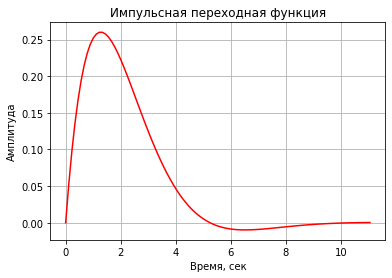

In [3]:
num = [2.]
den = [4., 5., 3.]

# создаем передаточную функцию
w = ct.tf(num, den)

# применяем единичный импульс
y, x = impulse(w)

# и строим график импульсной переходной функции
plt.plot(x, y, "r")
plt.title("Импульсная переходная функция") 
plt.ylabel("Амплитуда")
plt.xlabel("Время, сек")
plt.grid(True)
plt.show()

Однако, в реальности ситуация у нас обратная - мы знаем (точнее, можем получить) график импульсной переходной функции, а нам нужно восстановить по ней передаточную функцию (вернее, ее параметры).

Для этого мы воспользуемся следуюшим приемом: используем метод наименьших квадратов, чтобы подобрать коэффициенты передаточной функции таким образом, чтобы минимизировать ошибку (расхождение) между графиком импульсной передаточной функции, полученным экспериментальным путем. Фактически, мы хотим найти такие коэффициенты передаточной функции, чтобы график испульсной переходной функции, соответствующий этой передаточной функции, совпал с графиком, полученным эксперименатльным путем.

Для этого воспользуемся функцией `curve_fit` из пакета `scipy`.

Вначале рассмотрим работу этой функции на абстрактном примере, а затем применим эту функцию к нашим данным.

In [4]:
# импортируем нужные модули
import numpy as np
from scipy.optimize import curve_fit

In [5]:
# зададим функцию, для которой мы хотим подобрать параметры
def func(x, a, b, c):
    return a * np.exp(-b * x) + c

Пожалуйста, учитывайте, что функция должна уметь принимать на вход вектор (или массив) значений $x$, и выдавать вектор (массив) соответствуюших им значений $y$.

Именно поэтому в функции выше применена функция `np.exp` из модуля `NumPy` (она работает именно таким образом).

Вначале создадим "экспериментальные" данные:

1. Создадим массив `xdata` из чисел от 0 до 4, всего 50 значений
2. Построим соотвествующие им значения `y_ex`
3. Создадим "шум" `y_noise`
4. "Зашумим" данные (`ydata`)
5. Построим графики "чистых" и "зашумленных" значений `y`

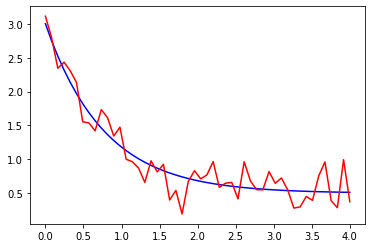

In [6]:
xdata = np.linspace(0, 4, 50)  # значения x
y_ex = func(xdata, 2.5, 1.3, 0.5)  # соответствующие "чистые" значения y
rng = np.random.default_rng()  # генератор случайных чисел
y_noise = 0.2 * rng.normal(size=xdata.size)  # шум
ydata = y_ex + y_noise  # "зашумленные" значения y
plt.plot(xdata, y_ex, 'b-', xdata, ydata, 'r-', label='data')

А теперь по "зашумленным" данным восстановим коэффициенты исходной функции (напомню, значения коэффициентов 2.5, 1.3, 0.5)

array([2.55982948, 1.43886056, 0.54188297])

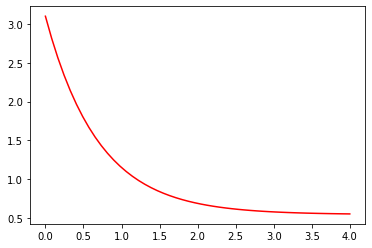

In [7]:
popt, pcov = curve_fit(func, xdata, ydata)  # находим коэффициенты
plt.plot(xdata, func(xdata, *popt), 'r-', label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
popt  # выводим кожффициенты

Теперь вернемся к нашей задаче.

Построим функцию, которая по значениям `x` (в нашем случае это время), и параметрам передаточной функции 

$$W = \frac{a}{bp^2 + cp + d}$$

рассчитывает значения импульсной переходной функции в соответствуюшие моменты времени:

In [8]:
def impulse_func(x, a, b, c, d):
    # построим из параметров числитель передаточной функции
    num = [a]
    # и ее знаменатель
    den = [b, c, d]
    
    # построим саму передаточную функцию
    w = ct.tf(num, den)
    
    # найдем переходную функцию в числовом виде
    ydata, xdata = impulse(w, T=x)
    
    return ydata

Найдем параметры (`popt`):

In [9]:
popt, pcov = curve_fit(impulse_func, x, y)

И вновь построим передаточную функцию (уже с вычисленными параметрами), 
по ней построим импульсную переходную функцию, и сравним ее с той, что мы построили в самом начале.

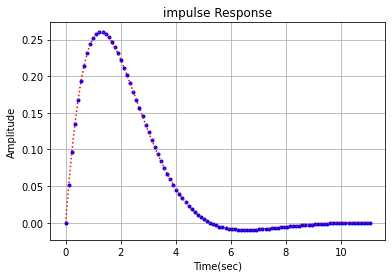

In [10]:
num_new = [popt[0]]
den_new = [popt[1], popt[2], popt[3]]

w_new = ct.tf(num_new, den_new)

y_new, x_new = impulse(w)

plt.plot(x, y, "b.", x_new, y_new, "r:")  # график исходной (x,y) и восстановленной (x_new, y_new) переходных функций
plt.title("impulse Response") 
plt.ylabel("Amplitude")
plt.xlabel("Time(sec)")
plt.grid(True)
plt.show()

Как можно видеть, графики переходных функций совпадают.
Построим теперь АЧХ и ФЧХ:

Text(0.5, 0.98, 'Bode Plot (Closed-Loop)')

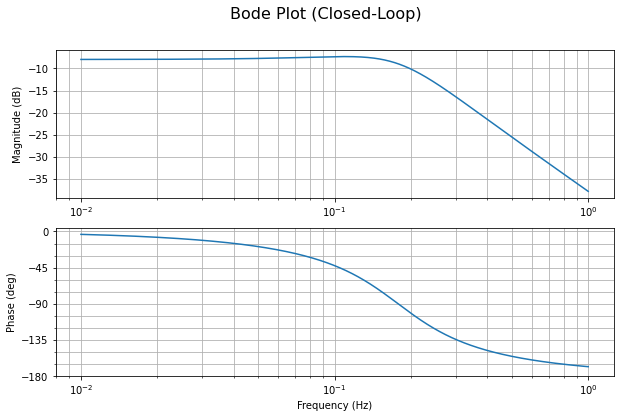

In [11]:
fb = ct.feedback(w_new, 1)  # найдем отклик системы на гармонические колебания

plt.figure(figsize=(10, 6))
ct.bode_plot(fb, dB=True, Hz=True, deg=True)
plt.suptitle("Bode Plot (Closed-Loop)", fontsize=16)

Теперь построим диаграмму Найквиста-Михайлова

Text(0.5, 1.0, 'Nyquist Plot (Closed-Loop)')

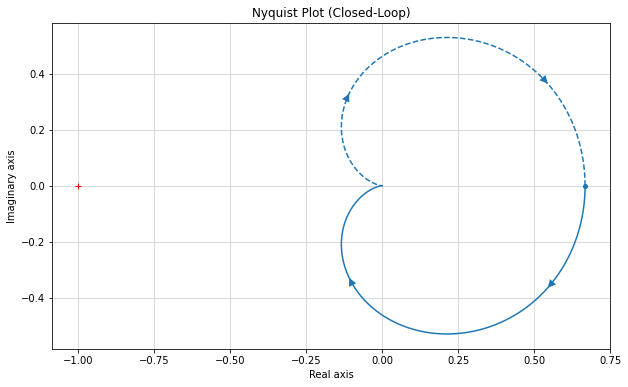

In [12]:
plt.figure(figsize=(10, 6))
ct.nyquist_plot(w_new)
plt.title("Nyquist Plot (Closed-Loop)")